In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
import sys
sys.path.append("../")
import functions as f
plt.style.use('seaborn-v0_8-whitegrid')
#plt.style.available
import seaborn as sns
import load_data as ld
import classes as cl
from sklearn import datasets
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Own code classification

In [2]:
# Prepare the dataset
data = pd.read_csv('../../data/Wisconsin.csv')

# Select features and target (radius_mean and texture_mean, diagnosis)
X = data[['radius_mean', 'texture_mean']].values
y = data['diagnosis'].apply(lambda x: 1 if x == 'M' else 0).values.reshape(-1, 1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Standardize the data. It does not make sense to standardize/scale the y values because they are binary.
X_train, X_test = f.scale_train_test(X_train, X_test)

# Set layer sizes: 2 (input), 16 (hidden), 8 (hidden), 1 (output)
input_size = 2
layer_sizes = [12, 12, 1]

activation_funcs = [f.ReLU, f.ReLU, f.sigmoid]

# Train the neural network
learning_rate = [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001]
epochs = 1000

accuracy_list = []

for lr in learning_rate:

    # Initialize layers and activation functions
    layers = f.create_layers_batch(input_size, layer_sizes)
    #print("Initialized layers:", layers)
    
    trained_layers = f.train_network(X_train, y_train, layers, activation_funcs, f.cost_cs, lr, epochs)

    # Predict on test data
    y_pred = f.feed_forward_batch(X_test, trained_layers, activation_funcs)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Calculate accuracy
    accuracy = np.mean(y_pred_classes == y_test)
    print(f"Accuracy: {accuracy:.4f}")

    accuracy_list.append(accuracy)

Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Epoch 0: Layer shapes:
Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 2), b shape = (12,)
Layer 1: 

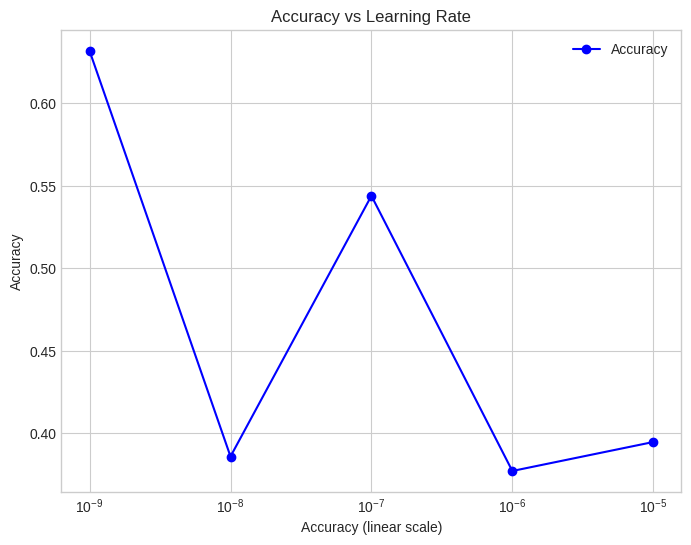

In [3]:
f.plot_metric_vs_learning_rate(learning_rate, accuracy_list, 'Accuracy', 'Accuracy (linear scale)', 'Accuracy vs Learning Rate')

## Pytorch code classification

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd


X, y = ld.load_wisconsin_data()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Set model parameters
input_size = X_train.shape[1]
hidden_size1 = 12
hidden_size2 = 12
output_size = 1

learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]

accuracy_list = []

for lr in learning_rates: 

    # Initialize the model, loss function, and optimizer
    model = cl.RegClasNN(input_size, hidden_size1, hidden_size2, output_size)
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if (epoch+1) % 100 == 0:
            #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_classes = (y_pred > 0.5).float()

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_classes.numpy())
    print(f"Accuracy: {accuracy:.4f}")

    accuracy_list.append(accuracy)



Accuracy: 0.6228
Accuracy: 0.6228
Accuracy: 0.9123
Accuracy: 0.9211
Accuracy: 0.9211


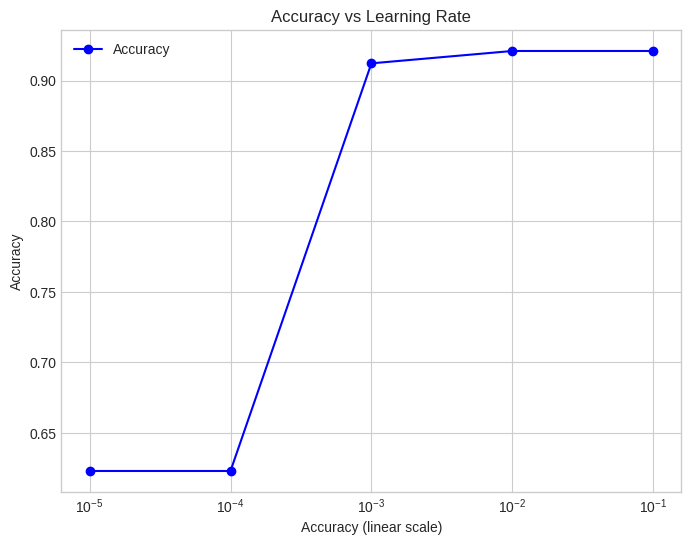

In [5]:
f.plot_metric_vs_learning_rate(learning_rates, accuracy_list, 'Accuracy', 'Accuracy (linear scale)', 'Accuracy vs Learning Rate')

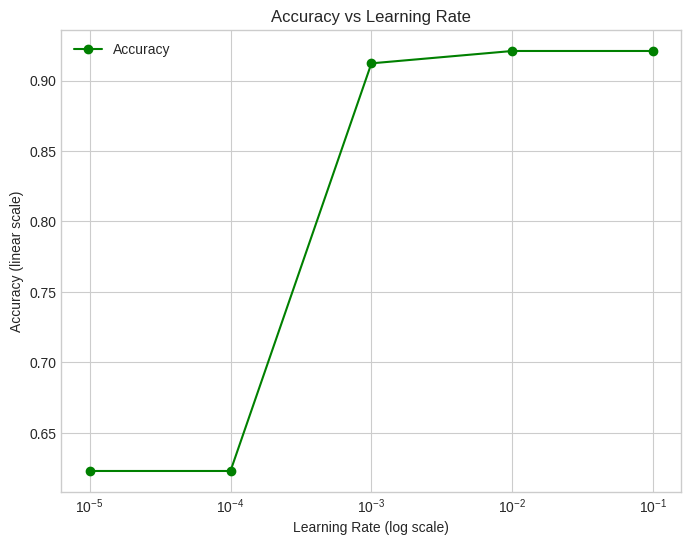

In [6]:
# Plotting accuracy vs learning rate
plt.figure(figsize=(8, 6))
plt.plot(learning_rates, accuracy_list, marker='o', linestyle='-', color='g', label='Accuracy')

# Log scale for x-axis (learning rates) and linear scale for y-axis (accuracy)
plt.xscale('log')  # Learning rates are typically plotted on a log scale
plt.yscale('linear')  # Accuracy is plotted on a linear scale

# Labels and title
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Accuracy (linear scale)')
plt.title('Accuracy vs Learning Rate')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()